## 2D Ising model

In [174]:
include("ising.jl") # using WangLandau
using StatsPlots, DataFrames, LinearAlgebra, LaTeXStrings

In [181]:
# Run simulation
L = 10
prob = WangLandauProblem(Ising2D(L; initial_state = -ones(Int, L, L)))

# solve(prob; final_logf = 1e-1)
sim = solve(prob; 
    # catchup = FixedFractionalCatchup(0.99), 
    final_logf = 1e-6,
    check_steps = 1e5)

[ Info: Starting simulation...
[ Info: ... done!


WangLandauSimulation{Ising2D}
  log(f) = 9.5367431640625e-7 (final: 1.0e-6)
  iterations: 20 (checks: 925)
  total steps: 92500000

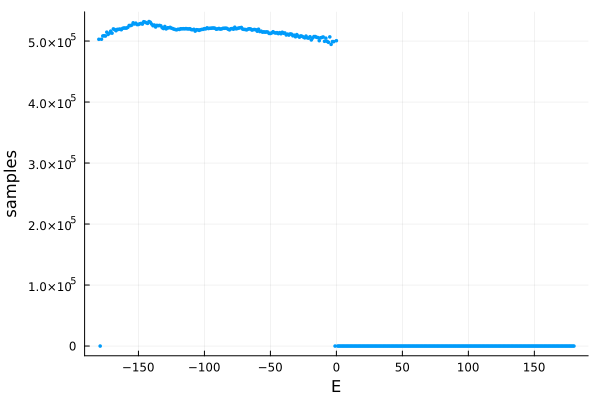

In [182]:
Erange = -sim.state.maxE:sim.state.maxE
scatter(Erange, sim.samples; label = :none, xlabel = "E", ylabel = "samples", msw = 0, ms = 2)

### Analysis

We have the entropy $\log g(E)$, from which we can calculate moments of the energy
$$ \langle E^n \rangle = \frac{\sum_E E^n g(E) \exp(-\beta E)}{\sum_E g(E) \exp(-\beta E)} $$

The 2D Ising model has a continuous phase transition at $\beta_c J = \log (1+\sqrt{2}) / 2 \approx 0.44\ldots$.

In [132]:
# Extract simulation data into a DataFrame
function extract_dos(sim, Es; min_visits = 0)
    mask = sim.samples .> min_visits
    logdos_shift = maximum(sim.logdos[mask])
    dos = exp.(sim.logdos[mask] .- logdos_shift)
    return DataFrame((; Es = Es[mask], dos))
end

extract_dos (generic function with 1 method)

In [125]:
# compute 
function moment_E(df, n, β)
    Es = df.Es
    dos = df.dos
    if n == 0
        E_factor = @. exp(-Es * β)
    else
        E_factor = @. Es^n * exp(-Es * β)
    end
    return dot(dos, E_factor)
end

moment_E (generic function with 1 method)

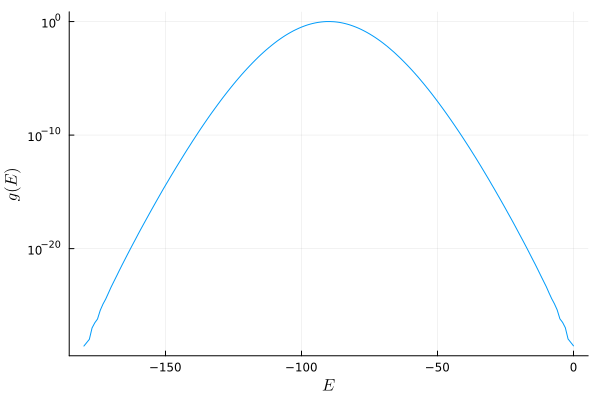

In [183]:
dos_df = extract_dos(sim, Erange);
@df dos_df plot(:Es, :dos; label = :none, xlabel = L"E", ylabel = L"g(E)", yscale = :log10)

In [178]:
βs = 0.1:0.01:2.0
Zs = [moment_E(dos_df, 0, β) for β in βs]
avgE = [moment_E(dos_df, 1, β) for β in βs]
avgE2 = [moment_E(dos_df, 2, β) for β in βs]
varE = @. (avgE2 / Zs - (avgE / Zs)^2) * βs^2;

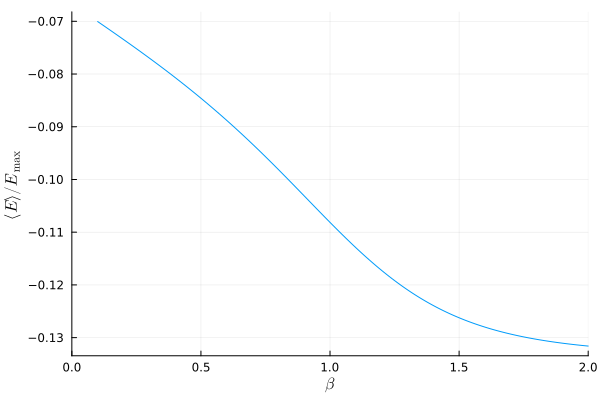

In [184]:
plot(βs, avgE ./ Zs ./ sim.state.maxE; label = :none, xlabel = L"\beta", ylabel = L"\langle E \rangle / E_\mathrm{max}", xlim = (0, Inf))

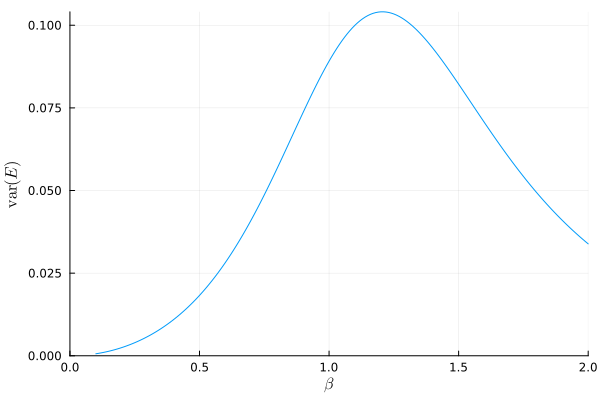

In [185]:
plot(βs, varE ./ L^2; label = :none, xlabel = L"\beta", ylabel = L"\mathrm{var}(E)", xlim = (0, Inf), ylim = (0, Inf))